### Imports

In [7]:
# !LD_LIBRARY_PATH=$HOME/miniconda3/lib:$LD_LIBRARY_PATH
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
import numpy as np
import tensorflow as tf
import keras
import os, shutil

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import regularizers
import seaborn as sns
from sklearn import metrics

TensorFlow version: 2.16.1
Keras version: 3.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Visualizing the data

In [9]:

def visualize_confusion_matrix_for_models(X_test, Y_test, *models) -> None:
    """
    Visualizes the confusion matrices for multiple machine learning models.

    Parameters:
        X_test (array-like): Test data features.
        Y_test (array-like): True labels for the test data.
        *models (variable-length argument list): Machine learning models to evaluate.

    Returns:
        None. Displays confusion matrices using seaborn's heatmap.
    """
    num_models = len(models)
    plt.figure(figsize=(5 * num_models, 5))
    for i, model in enumerate(models, 1):
        plt.subplot(1, num_models, i)
        Y_pred = model.predict(X_test)
        Y_pred = (Y_pred > 0.5)
        matrix = metrics.confusion_matrix(Y_test, Y_pred)
        hm = sns.heatmap(matrix,
                         cmap='coolwarm',
                         linecolor='white',
                         linewidths=1,
                         annot=True,
                         fmt='d')
        plt.yticks(rotation=0)
        hm.set_ylim(0, len(matrix))
        plt.title(f'Confusion Matrix - Model {i}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_accuracy_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation accuracy comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation accuracy values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = range(1, len(histories[0].history['acc']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



def plot_loss_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation loss comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation loss values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = range(1, len(histories[0].history['loss']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(epochs, loss, color + 'o', label=f'Training loss for {label}')
        plt.plot(epochs, val_loss, color, label=f'Validation loss for {label}')

    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
def print_val_accuracies(history1, history2, history3):
    val_accuracy1 = history1.history['val_acc']
    val_accuracy2 = history2.history['val_acc']
    val_accuracy3 = history3.history['val_acc']

    argmax1 = np.argmax(val_accuracy1)
    argmax2 = np.argmax(val_accuracy2)
    argmax3 = np.argmax(val_accuracy3)

    print ('Max accuracy for model 1 is: ', val_accuracy1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
    print ('Max accuracy for model 2 is: ', val_accuracy2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
    print ('Max accuracy for model 3 is: ', val_accuracy3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

### Get data

In [10]:
# The path to store trained models
models_dir = './models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where the original dataset was uncompressed
original_dataset_dir = './kaggle/original/train'

# The directory where we will store our smaller dataset
base_dir = './kaggle/processed/cats_and_dogs_small'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Preprocessing

## Generating more data 

In [15]:
img_rows = 150
img_cols = 150

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

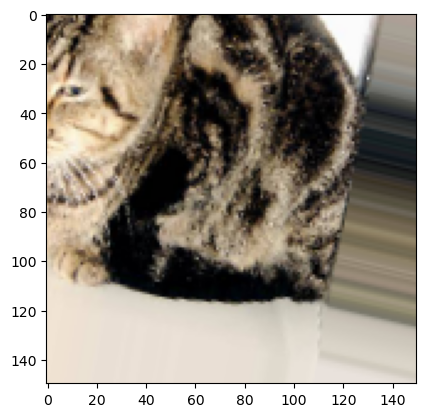

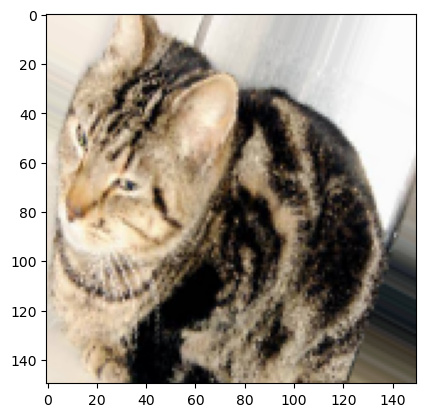

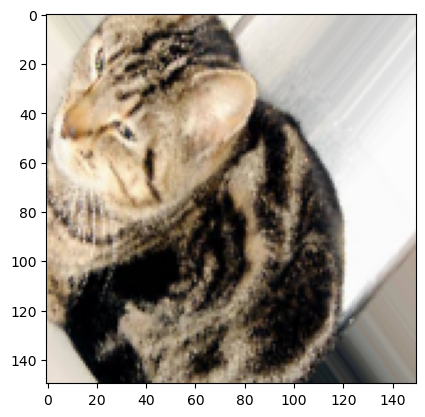

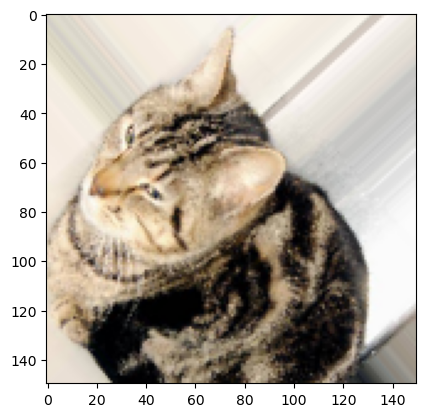

In [16]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(img_rows, img_cols))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

# Model

## Structure

In [17]:
from keras import layers
from keras import models
from keras import optimizers

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

model2.summary()


/home/lenovo/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-10 13:52:44.229512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 13:52:44.229636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 13:52:44.229687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NU

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,001 (1.98 MB)

 Trainable params: 520,001 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

#history2 = model2.fit_generator(
history2 = model2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100


/home/lenovo/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712749969.227011    2824 service.cc:145] XLA service 0x7f48c400bc70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712749969.227165    2824 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-04-10 13:52:49.330302: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 13:52:49.743984: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/100 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - acc: 0.7000 - loss: 0.6885  

I0000 00:00:1712749978.586857    2824 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - acc: 0.5243 - loss: 0.6934 - val_acc: 0.5000 - val_loss: 0.6922
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100


2024-04-10 13:53:12.162397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:53:12.162449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:53:12.162469: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:53:12.162503: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
/home/lenovo/miniconda3/envs/tf/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - acc: 0.5207 - loss: 0.6913 - val_acc: 0.5080 - val_loss: 0.6898
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100


2024-04-10 13:53:25.214731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:53:25.214807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:53:25.219139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:53:25.219191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:53:25.219201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:53:25.219228: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - acc: 0.5027 - loss: 0.6928 - val_acc: 0.5000 - val_loss: 0.6886
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100


2024-04-10 13:53:38.582319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:53:38.582393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:53:38.582404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:53:38.586511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:53:38.586564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:53:38.586575: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - acc: 0.5248 - loss: 0.6873 - val_acc: 0.5870 - val_loss: 0.6800
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100


2024-04-10 13:53:52.475194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:53:52.475270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:53:52.478881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:53:52.478934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:53:52.478944: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:53:52.478972: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - acc: 0.5754 - loss: 0.6765 - val_acc: 0.5610 - val_loss: 0.6734
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/100


2024-04-10 13:54:05.430731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:05.430812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:54:05.434904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:05.434957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:54:05.434967: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:54:05.434997: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - acc: 0.5844 - loss: 0.6676 - val_acc: 0.5970 - val_loss: 0.6647
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 101us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/100


2024-04-10 13:54:19.269000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:19.269101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:54:19.273176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:19.273233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:54:19.273244: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:54:19.273275: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - acc: 0.5669 - loss: 0.6775 - val_acc: 0.6000 - val_loss: 0.6575
Epoch 14/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/100


2024-04-10 13:54:32.309782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:32.309863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:54:32.313451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:32.313501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:54:32.313512: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:54:32.313540: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - acc: 0.5947 - loss: 0.6620 - val_acc: 0.5960 - val_loss: 0.6596
Epoch 16/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/100


2024-04-10 13:54:45.329606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:45.329678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:54:45.329710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:54:45.334189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:45.334244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:54:45.334255: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - acc: 0.5952 - loss: 0.6525 - val_acc: 0.6170 - val_loss: 0.6459
Epoch 18/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/100


2024-04-10 13:54:59.291961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:59.292021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:54:59.292032: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:54:59.292065: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 13:54:59.295474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:54:59.295526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - acc: 0.6163 - loss: 0.6541 - val_acc: 0.6120 - val_loss: 0.6529
Epoch 20/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/100


2024-04-10 13:55:12.093444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:55:12.093506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:55:12.093522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:55:12.093557: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 13:55:12.097163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:55:12.097218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - acc: 0.6188 - loss: 0.6388 - val_acc: 0.6140 - val_loss: 0.6404
Epoch 22/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/100


2024-04-10 13:55:25.987562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:55:25.987646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:55:25.991719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:55:25.991770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:55:25.991781: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:55:25.991832: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - acc: 0.6057 - loss: 0.6516 - val_acc: 0.5860 - val_loss: 0.6584
Epoch 24/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 97us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/100


2024-04-10 13:55:38.748457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:55:38.748508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:55:38.748519: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:55:38.748546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 13:55:38.752891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:55:38.752959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - acc: 0.6214 - loss: 0.6406 - val_acc: 0.6490 - val_loss: 0.6256
Epoch 26/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/100


2024-04-10 13:55:51.810049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:55:51.810114: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:55:51.810156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:55:51.813776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:55:51.813828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:55:51.813839: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - acc: 0.6365 - loss: 0.6236 - val_acc: 0.6540 - val_loss: 0.6206
Epoch 28/100


2024-04-10 13:56:05.716257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:05.716344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:56:05.722249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:05.722297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:56:05.722309: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:56:05.722340: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - acc: 0.6593 - loss: 0.6207 - val_acc: 0.6370 - val_loss: 0.6427
Epoch 30/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/100


2024-04-10 13:56:19.971457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:19.971509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:56:19.971520: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:56:19.971549: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 13:56:19.975222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:19.975274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - acc: 0.6509 - loss: 0.6238 - val_acc: 0.6500 - val_loss: 0.6136
Epoch 32/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 98us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/100


2024-04-10 13:56:33.958184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:56:33.958283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:33.958336: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:56:33.962989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:33.963057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:56:33.963073: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - acc: 0.6595 - loss: 0.5999 - val_acc: 0.6910 - val_loss: 0.5814
Epoch 34/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/100


2024-04-10 13:56:46.661033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:46.661117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:56:46.661137: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:56:46.661196: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 13:56:46.664725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:46.664807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - acc: 0.6698 - loss: 0.5936 - val_acc: 0.6840 - val_loss: 0.5919
Epoch 36/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/100


2024-04-10 13:56:59.545122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:59.545197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:56:59.545240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:56:59.549365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:56:59.549430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:56:59.549442: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - acc: 0.6986 - loss: 0.5937 - val_acc: 0.6950 - val_loss: 0.5856
Epoch 38/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/100


2024-04-10 13:57:13.396632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:57:13.396705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:57:13.400729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:57:13.400786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:57:13.400797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:57:13.400829: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - acc: 0.6886 - loss: 0.6037 - val_acc: 0.5940 - val_loss: 0.7106
Epoch 40/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/100


2024-04-10 13:57:26.462608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:57:26.462656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:57:26.462667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:57:26.462696: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 13:57:26.466714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:57:26.466771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - acc: 0.6694 - loss: 0.6033 - val_acc: 0.6580 - val_loss: 0.6006
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/100


2024-04-10 13:57:40.386868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:57:40.386943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:57:40.386990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:57:40.390915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:57:40.390975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:57:40.390987: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - acc: 0.6932 - loss: 0.5860 - val_acc: 0.6980 - val_loss: 0.5678
Epoch 44/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/100


2024-04-10 13:57:53.345018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:57:53.345095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:57:53.348723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:57:53.348797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:57:53.348809: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:57:53.348862: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - acc: 0.7217 - loss: 0.5679 - val_acc: 0.6860 - val_loss: 0.5941
Epoch 46/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/100


2024-04-10 13:58:06.321334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:06.321418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:58:06.325313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:06.325374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:58:06.325389: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:58:06.325429: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - acc: 0.6875 - loss: 0.5879 - val_acc: 0.6510 - val_loss: 0.6147
Epoch 48/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/100


2024-04-10 13:58:20.078635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:20.078687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:58:20.078698: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:58:20.078727: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 13:58:20.083124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:20.083182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - acc: 0.6844 - loss: 0.5741 - val_acc: 0.7110 - val_loss: 0.5585
Epoch 50/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/100


2024-04-10 13:58:33.072311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:33.072399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:58:33.076079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:33.076146: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:58:33.076166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - acc: 0.7077 - loss: 0.5728 - val_acc: 0.7020 - val_loss: 0.5681
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/100


2024-04-10 13:58:46.859888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:46.859940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:58:46.859951: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:58:46.859981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 13:58:46.864118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:46.864169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - acc: 0.6972 - loss: 0.5733 - val_acc: 0.6950 - val_loss: 0.5782
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/100


2024-04-10 13:58:59.767689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:59.767776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:58:59.771358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:58:59.771409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:58:59.771420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:58:59.771448: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - acc: 0.7002 - loss: 0.5655 - val_acc: 0.6880 - val_loss: 0.5801
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/100


2024-04-10 13:59:13.527768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:59:13.527852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:59:13.531818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:59:13.531896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:59:13.531933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - acc: 0.7046 - loss: 0.5663 - val_acc: 0.7130 - val_loss: 0.5489
Epoch 58/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 98us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/100


2024-04-10 13:59:26.481334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:59:26.481441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:59:26.485907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:59:26.485994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - acc: 0.7315 - loss: 0.5558 - val_acc: 0.6680 - val_loss: 0.6348
Epoch 60/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 96us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/100


2024-04-10 13:59:39.532104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:59:39.532153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:59:39.532164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:59:39.532194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 13:59:39.536802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:59:39.536866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - acc: 0.7010 - loss: 0.5710 - val_acc: 0.6860 - val_loss: 0.5847
Epoch 62/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 105us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/100


2024-04-10 13:59:53.429335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:59:53.429400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 13:59:53.434274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 13:59:53.434331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 13:59:53.434343: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 13:59:53.434375: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - acc: 0.7018 - loss: 0.5777 - val_acc: 0.7160 - val_loss: 0.5521
Epoch 64/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/100


2024-04-10 14:00:06.234819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:00:06.234903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:00:06.239169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:00:06.239231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:00:06.239243: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:00:06.239275: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - acc: 0.7146 - loss: 0.5617 - val_acc: 0.7410 - val_loss: 0.5410
Epoch 66/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/100


2024-04-10 14:00:19.817494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:00:19.817565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:00:19.821409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:00:19.821459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:00:19.821470: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:00:19.821497: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - acc: 0.7213 - loss: 0.5544 - val_acc: 0.7380 - val_loss: 0.5300
Epoch 68/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/100


2024-04-10 14:00:32.700644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:00:32.700699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:00:32.700712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:00:32.700748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 14:00:32.704455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:00:32.704508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - acc: 0.7249 - loss: 0.5428 - val_acc: 0.7110 - val_loss: 0.5957
Epoch 70/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/100


2024-04-10 14:00:46.052029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:00:46.052083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:00:46.052094: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:00:46.052125: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 14:00:46.055574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:00:46.055628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - acc: 0.7066 - loss: 0.5531 - val_acc: 0.7320 - val_loss: 0.5380
Epoch 72/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/100


2024-04-10 14:01:00.069458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:00.069540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:01:00.073339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:00.073393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:01:00.073404: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:01:00.073431: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - acc: 0.7164 - loss: 0.5450 - val_acc: 0.7270 - val_loss: 0.5451
Epoch 74/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/100


2024-04-10 14:01:13.182977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:13.183062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:01:13.187391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:13.187450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:01:13.187461: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:01:13.187491: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - acc: 0.7235 - loss: 0.5519 - val_acc: 0.7350 - val_loss: 0.5315
Epoch 76/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/100


2024-04-10 14:01:26.950845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:26.950926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:01:26.954394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:26.954449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:01:26.954460: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:01:26.954487: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - acc: 0.7098 - loss: 0.5494 - val_acc: 0.7210 - val_loss: 0.5523
Epoch 78/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/100


2024-04-10 14:01:40.141052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:40.141130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:01:40.145139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:40.145206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:01:40.145223: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:01:40.145260: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - acc: 0.7513 - loss: 0.5202 - val_acc: 0.7300 - val_loss: 0.5330
Epoch 80/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/100


2024-04-10 14:01:52.926829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:52.926906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:01:52.931217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:01:52.931276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:01:52.931287: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:01:52.931319: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - acc: 0.7308 - loss: 0.5299 - val_acc: 0.7340 - val_loss: 0.5502
Epoch 82/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 97us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/100


2024-04-10 14:02:06.577426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:06.577481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:02:06.577492: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:02:06.577524: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 14:02:06.580984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:06.581040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - acc: 0.7415 - loss: 0.5214 - val_acc: 0.7450 - val_loss: 0.5334
Epoch 84/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 98us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/100


2024-04-10 14:02:19.354020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:19.354121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:02:19.357815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:19.357869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:02:19.357880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:02:19.357907: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - acc: 0.7200 - loss: 0.5484 - val_acc: 0.7390 - val_loss: 0.5163
Epoch 86/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/100


2024-04-10 14:02:32.899784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:32.899864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:02:32.903663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:32.903728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:02:32.903742: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:02:32.903778: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - acc: 0.7565 - loss: 0.5111 - val_acc: 0.7440 - val_loss: 0.5140
Epoch 88/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/100


2024-04-10 14:02:45.508261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:45.508344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:02:45.508358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:02:45.508396: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 14:02:45.512062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:45.512114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - acc: 0.7293 - loss: 0.5200 - val_acc: 0.7570 - val_loss: 0.5090
Epoch 90/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/100


2024-04-10 14:02:58.280686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:58.280762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:02:58.284415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:02:58.284470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:02:58.284480: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:02:58.284509: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - acc: 0.7561 - loss: 0.4914 - val_acc: 0.7320 - val_loss: 0.5315
Epoch 92/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 115us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/100


2024-04-10 14:03:11.796981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:03:11.797071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:03:11.801753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:03:11.801841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - acc: 0.7587 - loss: 0.5026 - val_acc: 0.7160 - val_loss: 0.5677
Epoch 94/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/100


2024-04-10 14:03:24.523570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:03:24.523650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:03:24.527737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:03:24.527797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:03:24.527808: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:03:24.527835: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - acc: 0.7585 - loss: 0.4984 - val_acc: 0.7580 - val_loss: 0.5150
Epoch 96/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/100


2024-04-10 14:03:38.312842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:03:38.312910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:03:38.316705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:03:38.316756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:03:38.316767: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:03:38.316794: I tensorflow/core/framework/local_ren

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - acc: 0.7571 - loss: 0.5046 - val_acc: 0.7520 - val_loss: 0.5197
Epoch 98/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/100


2024-04-10 14:03:51.063889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:03:51.063941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:03:51.063953: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:03:51.063982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11647954665578102262
2024-04-10 14:03:51.067745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:03:51.067795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: O

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - acc: 0.7624 - loss: 0.5053 - val_acc: 0.7300 - val_loss: 0.5486
Epoch 100/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00


2024-04-10 14:04:03.829541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:04:03.829614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-10 14:04:03.833710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-10 14:04:03.833759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-10 14:04:03.833770: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6106647889654204231
2024-04-10 14:04:03.833797: I tensorflow/core/framework/local_ren

## Save model

In [19]:
model2.save(models_dir + 'cats_and_dogs_small_2.h5')


## Visualizing the metrics

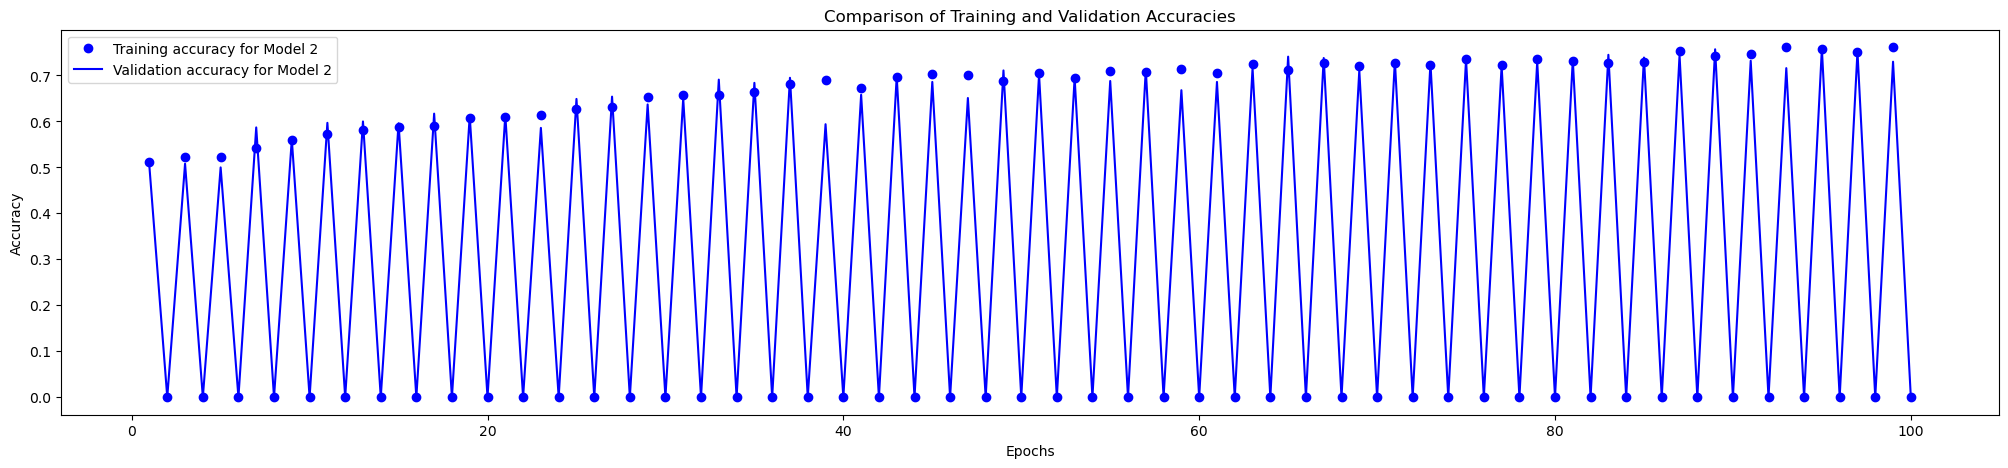

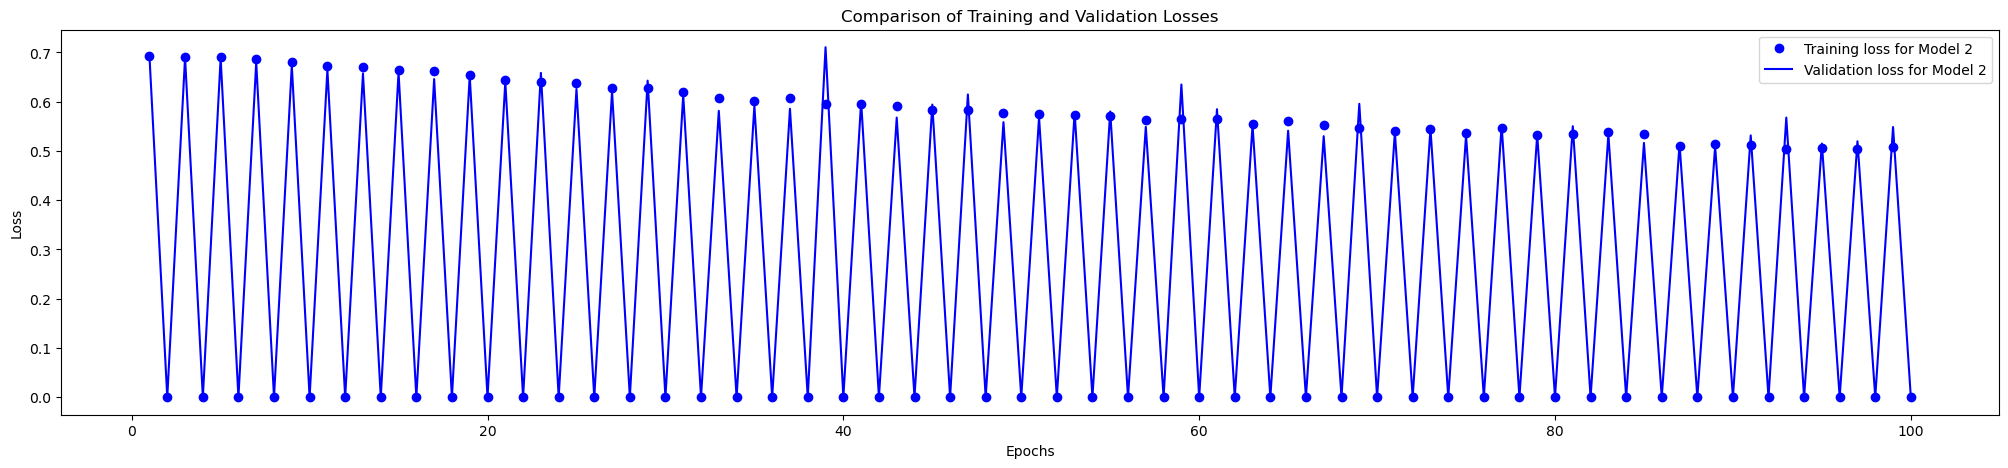

Max accuracy for model 1 is:  0.7580000162124634 , achieved in the  94 epoch.
Max accuracy for model 2 is:  0.7580000162124634 , achieved in the  94 epoch.
Max accuracy for model 3 is:  0.7580000162124634 , achieved in the  94 epoch.


In [20]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plot_accuracy_comparison(history2, labels=['Model 2'])
plot_loss_comparison(history2, labels=['Model 2'])
print_val_accuracies(history2, history2, history2)
